In [12]:
import math
import os
import warnings
from glob import glob
from itertools import cycle

import matplotlib.pyplot as plt
plt.style.use("grayscale")
font = {'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)

import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import matplotlib.backends.backend_pdf as plt_bc

In [13]:
def rounddown(x):
     return int(math.ceil(x / 100.0)) * 100 - 100

def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

def get_column_from_many_csv(filenames, col_num):
    intermediate_df = pd.DataFrame()
    for i, path in enumerate(filenames):
        df = pd.read_csv(path, skiprows=1)
        intermediate_df[i] = df.iloc[:, col_num]
    return intermediate_df

def save_all_plots(file_name):
    pdf = plt_bc.PdfPages(f"{file_name}.pdf")
    for fig in range(1, plt.gcf().number + 1):
        pdf.savefig( fig )
    pdf.close()

In [14]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [15]:
def read_averaging_data(ac_glob, normal_glob):
    ac_to_avg = glob(ac_glob)
    normal_to_avg = glob(normal_glob)

    avg_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y'])
    avg_comp.drop(['x', 'y'], axis=1, inplace=True)

    avg_comp['ac_iter_time'] = get_column_from_many_csv(ac_to_avg, 2).min(axis=1)
    avg_comp['norm_iter_time'] = get_column_from_many_csv(normal_to_avg, 2).min(axis=1)

    return avg_comp

In [16]:
def cumulate_data(data):
    data['ac_iter_time']=data["ac_iter_time"].cumsum()
    data['norm_iter_time']=data["norm_iter_time"].cumsum()
    return data

In [17]:
def read_more_averaging_data(dir_path = "results/final/coverage/all", data_column=2, path="*sc_stress_*", func=np.min):
    atomic = glob(f"{dir_path}/{path}/*")
    df = pd.read_csv(atomic[0], skiprows=2, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y', 'z'])
    df.drop(['ac_iter_time','x', 'y', 'z'], axis=1, inplace=True)
    for test_data in sorted(glob(f"{dir_path}/*")):
        data = glob(f"{test_data}/*")
        df[os.path.basename(test_data)] = func(get_column_from_many_csv(data, data_column), axis=1)

    return df

In [18]:
def create_plot_ac_comp(df, cumulative=False, clean=3, smooth = 100, cross_pairs=[]):
    fig, ax = plt.subplots(figsize=(15, 6))

    iteration_no = df['iteration_no']
    ac_coverage = df["ac_coverage"]

    df.drop(['iteration_no','ac_coverage',], axis=1, inplace=True)

    if smooth != -1:
        smooth_df = pd.DataFrame()
        for time in df:
            _, ac_iter_time_smooth = smoothen_plot(iteration_no, df[time], smooth)
            smooth_df[time] = ac_iter_time_smooth
        iteration_no_smooth, ac_coverage_smooth = smoothen_plot(iteration_no, ac_coverage, smooth)
        smooth_iteration_no = iteration_no_smooth
        smooth_ac_coverage = ac_coverage_smooth
    else:
        smooth_iteration_no = iteration_no.to_numpy()
        smooth_ac_coverage = ac_coverage.to_numpy()
        smooth_df = df

    ax.set_xlabel('Iteration', fontsize=20)
    if cumulative:
        ax.set_ylabel('Elapsed time [s]',fontsize=20)
        normalized_df = smooth_df.apply(lambda x: x / (10**9))
        normalized_df = normalized_df.apply(lambda x: x.cumsum())
    else:
        ax.set_ylabel('Time of 10 iterations [ms]',fontsize=20)
        normalized_df = smooth_df.apply(lambda x: x / (10**6))

    line_styles = cycle([":", "--", "-.", "-"])
    marker_styles = cycle(("X", "o", "*", "+", "*", "X", ".", "x"))
    for file_name_with_params in normalized_df:
        ax.plot(smooth_iteration_no,
                normalized_df[file_name_with_params],
                linestyle=next(line_styles),
                marker=next(marker_styles),
                label=file_name_with_params,
                )
    full_grid = np.where(smooth_ac_coverage >= 1.0)[0][0]

    cross_points = []
    for (cross1, cross2) in cross_pairs:
        diff_list = (normalized_df[cross1] - normalized_df[cross2]).abs()
        cross_point = np.where(diff_list < 1)[0][0]
        cross_points.append(cross_point)
        ax.axvline(x=smooth_iteration_no[cross_point], lw=1, ls='--', c='black')
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.text(smooth_iteration_no[cross_point] - x_lim[1] * .02,
                (y_lim[1] - y_lim[0]) * .05 + y_lim[0],
                'Iteration time crossover', rotation=90)

    xs = (
      [full_grid - 2] +
      list(range(0, len(smooth_iteration_no) , round(len(smooth_iteration_no) / 6) ))

    )
    xs.pop()
    xs.extend(cross_points)
    xticks = [smooth_iteration_no[i]  for i in xs]


    ax.set_xticks([rounddown(i) for i in xticks])

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA', fontsize=20, labelpad=10)

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{smooth_ac_coverage[i] * 100:.0f}%'
        for i in xs
    ])

    plt.legend()
    return fig

In [19]:
if not os.path.isdir("charts"):
    os.makedirs("charts")

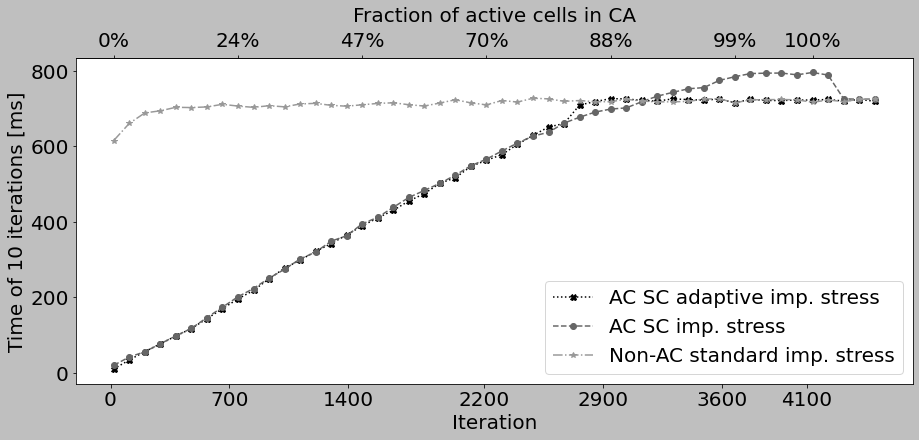

In [20]:
df = read_more_averaging_data(dir_path = "results/paper/coverage/stress", func=np.median)
df.columns = ["iteration_no", "ac_coverage", "AC SC adaptive imp. stress", "AC SC imp. stress", "Non-AC standard imp. stress"]

create_plot_ac_comp(df, smooth=50)
plt.savefig("charts/coverage_stress.pdf")

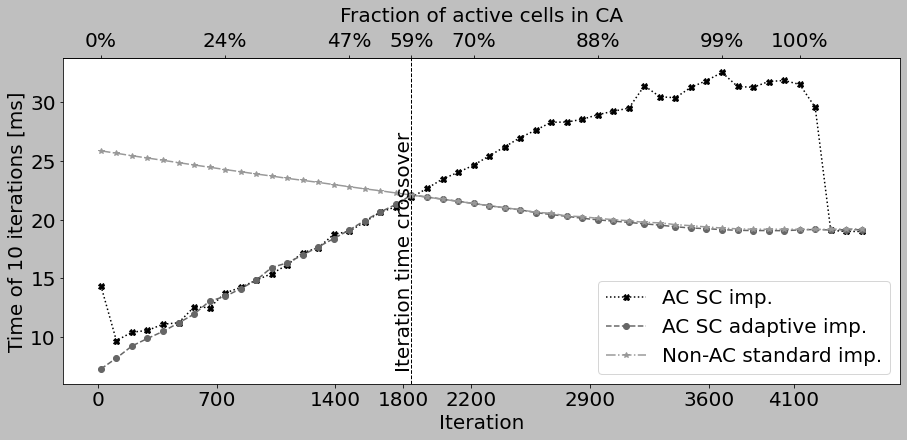

In [24]:
df = read_more_averaging_data(dir_path = "results/paper/coverage/normal", path="*sc_4*")
df.columns = ["iteration_no", "ac_coverage", "AC SC imp.", "AC SC adaptive imp.", "Non-AC standard imp."]

create_plot_ac_comp(df, smooth=50, cross_pairs=[("AC SC imp.", "Non-AC standard imp.")])
plt.savefig("charts/coverage.pdf")

In [ ]:
df = read_more_averaging_data(dir_path = "results/paper/coverage/normal", path="*sc_4*")
df.columns = ["iteration_no", "ac_coverage", "AC SC imp.", "AC SC adaptive imp.", "Non-AC standard imp."]

create_plot_ac_comp(df, smooth=50, cumulative=True)
plt.savefig("charts/coverage_cumulative.pdf")